# Transfer Learning approach on handwriting recognition

### Libraries importing

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import backend as K
from PIL import Image

### Downloading the dataset from Kaggle
### Ref: [Guide](https://stackoverflow.com/questions/49310470/using-kaggle-datasets-in-google-colab)

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"marcozenere","key":"45ced8390a13476bc66013f1432346a8"}'}

In [3]:
!pip install -q kaggle

In [4]:
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d landlord/handwriting-recognition

 99% 1.25G/1.26G [00:43<00:00, 35.3MB/s]
100% 1.26G/1.26G [00:43<00:00, 31.3MB/s]


In [7]:
!ls

handwriting-recognition.zip  kaggle.json  sample_data


In [8]:
!mkdir dataset

In [9]:
!unzip handwriting-recognition.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/validation_v2/validation/VALIDATION_5003.jpg  
  inflating: dataset/validation_v2/validation/VALIDATION_5004.jpg  
  inflating: dataset/validation_v2/validation/VALIDATION_5005.jpg  
  inflating: dataset/validation_v2/validation/VALIDATION_5006.jpg  
  inflating: dataset/validation_v2/validation/VALIDATION_5007.jpg  
  inflating: dataset/validation_v2/validation/VALIDATION_5008.jpg  
  inflating: dataset/validation_v2/validation/VALIDATION_5009.jpg  
  inflating: dataset/validation_v2/validation/VALIDATION_5010.jpg  
  inflating: dataset/validation_v2/validation/VALIDATION_5011.jpg  
  inflating: dataset/validation_v2/validation/VALIDATION_5012.jpg  
  inflating: dataset/validation_v2/validation/VALIDATION_5013.jpg  
  inflating: dataset/validation_v2/validation/VALIDATION_5014.jpg  
  inflating: dataset/validation_v2/validation/VALIDATION_5015.jpg  
  inflating: dataset/validation_v2/validation/VALIDATION_5016.jpg

### Loading and visualization of the dataset 

In [10]:
train = pd.read_csv('dataset/written_name_train_v2.csv')
valid = pd.read_csv('dataset/written_name_validation_v2.csv')

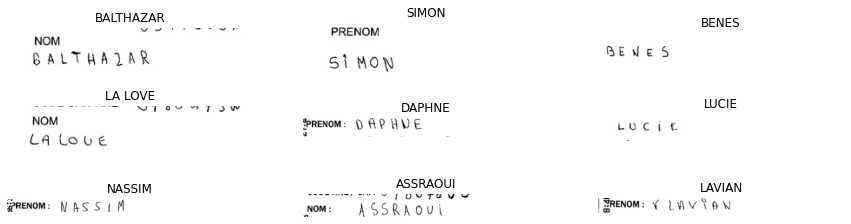

In [11]:
plt.figure(figsize=(15, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    img_dir = 'dataset/train_v2/train/' + train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

### Preprocessing

#### Checking for NaN values and removing them

In [12]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  565
Number of NaNs in validation set :  78


In [13]:
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)

#### In the 'IDENTITY' column some rows have as value 'UNREADABLE'. Let's see some examples and then remove

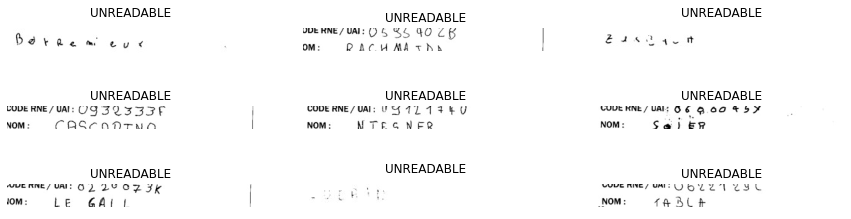

In [14]:
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    img_dir = 'dataset/train_v2/train/' + unreadable.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [15]:
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

#### Some labels are in lowercase. To maintain uniformityall the labels are converted to uppercase.

In [16]:
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()

In [17]:
train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)

In [18]:
# Function used for removing undesired labels in the images
def crop_picture(PATH, verbose=False):
    # load image
    img = Image.open(PATH)
    pixels=img.convert('1').load()
    # get dimensions
    w, h = img.size
        
    # Create a smaller frame in the center of the image
    # ws = width start, we = width end, hs ... , he ...
    ws = int(w * 0.4) # width starts from 40%
    we = int(w * 0.7) # goes until 70 %
    hs = int(0.5 * h) # height starts from 50%
    he = hs + 4 # int(0.52 * h) # goes until 50% + 4 pixels
    # save dimensions of the frame
    cur_frame = [ws, hs, we, he]
    # current (smaller) image
    cur_img = img.crop(tuple(cur_frame)).convert('1') # '1' for 1-bit pixels, black and white, stored with one pixel per byte
    # pixels inside this frame only
    cur_pixels = cur_img.load()
    # compute image's entropy
    entropy = cur_img.entropy()

    # define a threshold for each line to stop searching for new black pixels
    thr_val_vert = 2
    thr_val_hor = 16
    # starting thresholds
    threshold = [thr_val_vert, int(0.2*h), thr_val_hor, thr_val_hor]
    
    # we need to keep searching to the left until first black found
    black_found_w = False
    
    # Start expanding the frame to every edge, until only white pixels are found
    while (ws >= 0 or hs >= 0 and we < w and he < h):
        
        # define the four lines of the frame
        line_up = [cur_pixels[l, 0] for l in range(we-ws)]
        line_down = [cur_pixels[l, he-hs-1] for l in range(we-ws)]
        line_left = [cur_pixels[0, l] for l in range(he-hs)]
        line_right = [cur_pixels[we-ws-1, l] for l in range(he-hs)]
        # save them in a list
        lines = [line_left, line_up, line_right, line_down]
        
        
        
        # if a line contains black pixel(s) or threshold has not been exceeded, expand it
        # if a dimension has reached its end, stop changing it by setting the threshold to 0
        if threshold[0] > 0 or 0 in line_up:
            hs = max(0, hs-1)
            if 0 in line_up and hs > 0:
                threshold[0] = thr_val_vert
            else:
                threshold[0] -= 1
        
        if threshold[1] > 0 or 0 in line_down:
            he = min(h, he+1)
            if 0 in line_down and he < h:
                threshold[1] = thr_val_vert

                # if black found on the bottom line, move down also the upper line
                hs += 1
            else:
                threshold[1] -= 1
        
        if threshold[2] > 0:
            ws -= 1
            if 0 in line_left:
                threshold[2] = thr_val_hor
                black_found_w = True
            elif black_found_w:
                threshold[2] -= 1
        
        if threshold[3] > 0:
            we += 1
            if 0 in line_right:
                threshold[3] = 4
            else:
                threshold[3] -= 1
        
        threshold[0] = max(threshold[0] * int(not hs == 1), 0)
        threshold[1] = max(threshold[1] * int(not he == h - 1), 0)
        threshold[2] = max(threshold[2] * int(not ws == 1), 0)
        threshold[3] = max(threshold[3] * int(not we == w - 1), 0)


        # if all lines are totally white, no expand needed. Otherwise, it will expand
        if [ws, hs, we, he] != cur_frame:            
            # change dimensions of the frame - expand it
            cur_frame = [ws, hs, we, he]
            # current - smaller - image
            cur_img = img.crop(tuple(cur_frame)).convert('1')
            # pixels inside this frame only
            cur_pixels = cur_img.load()
            # get image entropy
            entropy = cur_img.entropy()
        elif threshold == [0] * 4:
            break
        
        # Printing
        if verbose:
            print("Image dimensions: ", h, w, "Current frame: ", cur_frame)
            print("Thresholds: ", threshold)
            #print(lines)
            
            plt.figure(figsize=(10, 10))
            ax = plt.subplot(1, 2, 1)
            plt.imshow(np.asarray(img), cmap='gray')
            ax = plt.subplot(1, 2, 2)
            plt.imshow(np.asarray(cur_img), cmap= 'gray')
    
    if 0.37 > entropy > 0.11:
        returned_img = cv2.imread(PATH, cv2.IMREAD_GRAYSCALE)
        return returned_img[hs:he, ws:we], entropy
    else:
        return None, entropy

In [19]:
# Function used for resizing the images to the desired dimension
def imageResize(img):
    # Input: 
    # img : a black and white image of dimension (h,w)
    # Output:
    # an image of a desired dimension
    
    (h, w) = img.shape
    
    # blank white image
    final_img = np.ones([50, 200])*255 
    
    # crop
    if w > 200:
        img = img[:, :200]
        
    if h > 50:
        img = img[:50, :]
    
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

### Sample of images after the preprocessing

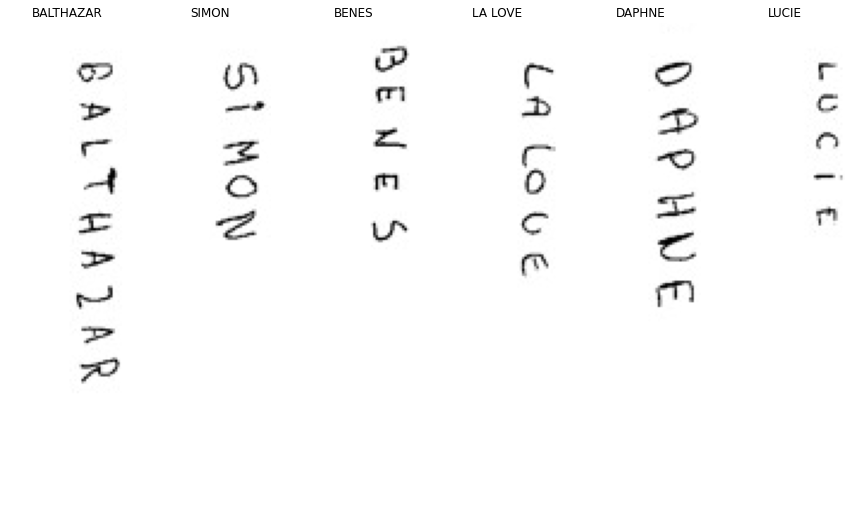

In [20]:
plt.figure(figsize=(15, 10))

images= []
i = 0

while len(images) < 6:
  img_dir = 'dataset/train_v2/train/' + train.loc[i, 'FILENAME']
  image, entropy = crop_picture(img_dir)
  if not image is None:
    images.append(image)
  i += 1

i = 0
for image in images:
  ax = plt.subplot(1, 6, i+1)
  plt.imshow(image, cmap='gray')
  image = imageResize(image)
  image = image/255.
  plt.imshow(image, cmap = 'gray', aspect='equal')
  plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
  plt.axis('off')
  i += 1
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

#### Retriving of 30000 images

In [21]:
images = []
labels = []
i = 0

while len(images) < 30000 :
  try:
    text = (valid.loc[i,'IDENTITY']).strip() 
  
    # Limit to the maximal length of the labels 
    if(len(text) <= 23):
      img_dir = 'dataset/validation_v2/validation/' + valid.loc[i, 'FILENAME']
      image, entropy = crop_picture(img_dir)
      if not image is None:
        image = imageResize(image)
        image = image/255.
        
        images.append(image)
        labels.append(text)
  except:
    print("Image number " + str(i) + " doesn't exist") 
  i += 1

In [22]:
len(images)

30000

In [23]:
characters = sorted(set(char for label in labels for char in label))
max_length = max([len(label) for label in labels])

In [24]:
print("Maximal length of the labels: ", max_length)
print("Number of unique characters : ", len(characters))
print("Characters present          : ", characters)

Maximal length of the labels:  21
Number of unique characters :  29
Characters present          :  [' ', "'", '-', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


#### Splitting of the image into a training and validation dataset

In [25]:
x_train = images[:27000]
y_train = labels[:27000]
x_valid = images[27000:]
y_valid = labels[27000:]

#### Conversion of labels into a numeric representation

In [26]:
def encode_to_labels(txt):
    # Input:
    # txt : label in characters form
    # Output:
    # label in digits form
    dig_lst = []
    
    # Parsing of the label
    for index, char in enumerate(txt):
        try:
            dig_lst.append(characters.index(char))
        except:
            print(char)
        
    return dig_lst

#### The labels don't have a fixed length. The padding operation adjust this problem

In [27]:
train_labels_encoded_ = list(map(encode_to_labels, y_train))
train_labels = tf.keras.preprocessing.sequence.pad_sequences(
    train_labels_encoded_,maxlen = max_length, padding="post", value = len(characters)
    )

In [28]:
valid_labels_encoded_ = list(map(encode_to_labels, y_valid))
valid_labels = tf.keras.preprocessing.sequence.pad_sequences(
    valid_labels_encoded_, maxlen = max_length, padding="post", value = len(characters)
    )

In [29]:
x_train = np.array(x_train)
x_valid = np.array(x_valid)
x_train = x_train.reshape(-1, 200, 50, 1)
x_valid = x_valid.reshape(-1, 200, 50, 1)

# Model construction

#### The base model was pretrained with captcha images
#### Ref: [OCR model for reading Captchas](https://keras.io/examples/vision/captcha_ocr/)

In [30]:
base_model = tf.keras.models.load_model('/content/OCR_Captcha_images.h5') 

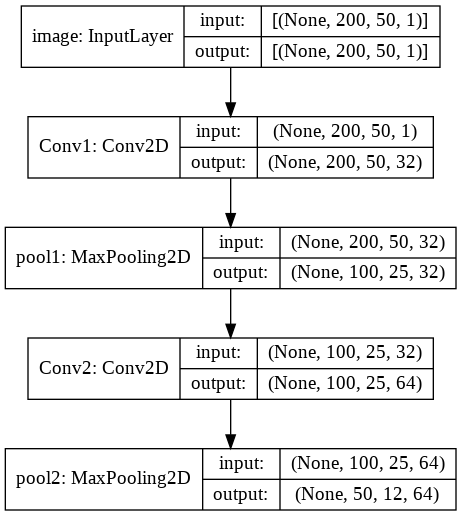

In [32]:
tf.keras.utils.plot_model(base_model, to_file='/content/base_model_architecture.png', show_shapes=True)

In [33]:
base_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 200, 50, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 200, 50, 32)       320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 100, 25, 32)       0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 100, 25, 64)       18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 50, 12, 64)        0         
Total params: 18,816
Trainable params: 18,816
Non-trainable params: 0
_________________________________________________________________


In [34]:
base_model.trainable = False

#### CTC layer defined as Keras layer

In [35]:
# Ref: https://keras.io/examples/vision/captcha_ocr/

class CTCLayer(tf.keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

#### Model definition

In [36]:
inputs = tf.keras.Input(name = 'input', shape = (200,50,1))

x = base_model(inputs, training = False)

labels = tf.keras.layers.Input(name="label", shape=(None,), dtype="float32")

# CNN
x = tf.keras.layers.Conv2D(128,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv3",)(x)
x = tf.keras.layers.MaxPooling2D((2, 2), name="pool3")(x)
x = tf.keras.layers.Reshape(target_shape=((25,768)), name="reshape")(x)
x = tf.keras.layers.Dense(64, activation="relu", name="dense1")(x)
x = tf.keras.layers.Dropout(0.3)(x)

# RNNs
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.25))(x)

#OUTPUT
softmax_output = tf.keras.layers.Dense(len(characters) + 1, kernel_initializer = 'he_normal', activation = 'softmax',name='dense2')(x)
outputs = CTCLayer(name = 'ctc_loss')(labels,softmax_output)

model = tf.keras.models.Model([inputs,labels], outputs)

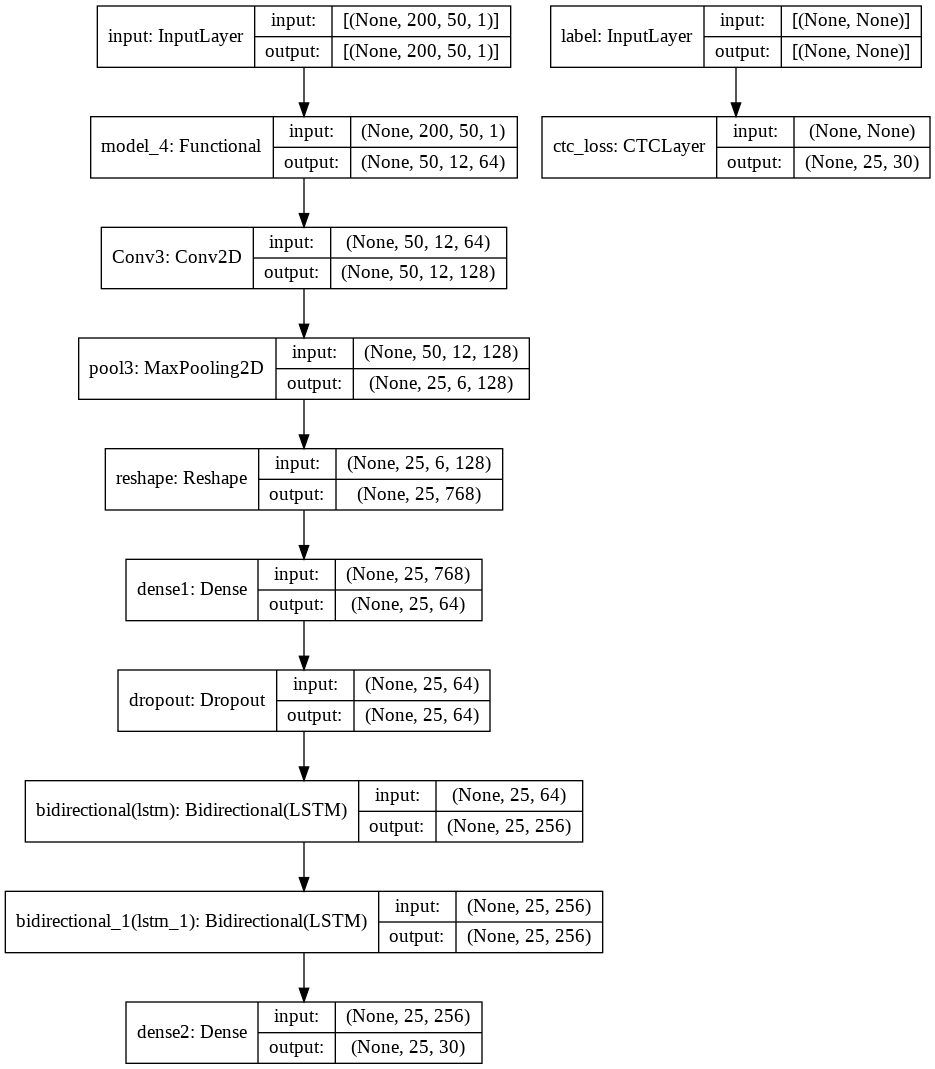

In [37]:
tf.keras.utils.plot_model(model, to_file='/content/final_model_architecture.png', show_shapes=True)

In [38]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 200, 50, 1)] 0                                            
__________________________________________________________________________________________________
model_4 (Functional)            (None, 50, 12, 64)   18816       input[0][0]                      
__________________________________________________________________________________________________
Conv3 (Conv2D)                  (None, 50, 12, 128)  73856       model_4[0][0]                    
__________________________________________________________________________________________________
pool3 (MaxPooling2D)            (None, 25, 6, 128)   0           Conv3[0][0]                      
______________________________________________________________________________________________

#### The project used the Keras Transfer Learning and Fine-Tuning technique 
#### Ref: [Transfer Learning](https://keras.io/guides/transfer_learning/)

In [39]:
model.compile(optimizer = 'adam')

In [40]:
# Add early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

history = model.fit([x_train,train_labels],
                    validation_data=[x_valid, valid_labels],
                    epochs=40,
                    batch_size=64, 
                    callbacks=[early_stopping])

Epoch 1/40
422/422 [==============================] - 60s 111ms/step - loss: 20.9491 - val_loss: 17.9860
Epoch 2/40
422/422 [==============================] - 45s 106ms/step - loss: 16.6966 - val_loss: 10.2685
Epoch 3/40
422/422 [==============================] - 45s 107ms/step - loss: 9.6717 - val_loss: 5.5284
Epoch 4/40
422/422 [==============================] - 44s 105ms/step - loss: 6.3593 - val_loss: 4.4624
Epoch 5/40
422/422 [==============================] - 44s 105ms/step - loss: 5.3284 - val_loss: 3.8358
Epoch 6/40
422/422 [==============================] - 45s 106ms/step - loss: 4.6479 - val_loss: 3.5376
Epoch 7/40
422/422 [==============================] - 45s 106ms/step - loss: 4.2179 - val_loss: 3.3607
Epoch 8/40
422/422 [==============================] - 45s 107ms/step - loss: 3.9311 - val_loss: 3.2601
Epoch 9/40
422/422 [==============================] - 45s 106ms/step - loss: 3.7519 - val_loss: 3.0213
Epoch 10/40
422/422 [==============================] - 45s 106ms/step

#### Learning curves

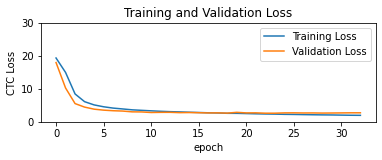

In [41]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('CTC Loss')
plt.ylim([0,30.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### Fine Tuning 

In [42]:
base_model.trainable = True

In [43]:
# 1/10 of the default learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
)

In [44]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=2, restore_best_weights=True
)
history_fine = model.fit([x_train,train_labels],
                         validation_data=[x_valid, valid_labels],
                         epochs=10,
                         batch_size=64, 
                         callbacks=[early_stopping])

Epoch 1/10
422/422 [==============================] - 56s 116ms/step - loss: 2.1224 - val_loss: 2.5309
Epoch 2/10
422/422 [==============================] - 48s 114ms/step - loss: 1.9990 - val_loss: 2.4999
Epoch 3/10
422/422 [==============================] - 48s 115ms/step - loss: 2.0622 - val_loss: 2.4877
Epoch 4/10
422/422 [==============================] - 49s 115ms/step - loss: 2.0025 - val_loss: 2.4735
Epoch 5/10
422/422 [==============================] - 48s 114ms/step - loss: 1.9968 - val_loss: 2.4695
Epoch 6/10
422/422 [==============================] - 48s 115ms/step - loss: 1.9442 - val_loss: 2.4643
Epoch 7/10
422/422 [==============================] - 48s 115ms/step - loss: 1.9692 - val_loss: 2.4572
Epoch 8/10
422/422 [==============================] - 49s 116ms/step - loss: 1.9439 - val_loss: 2.4601
Epoch 9/10
422/422 [==============================] - 49s 116ms/step - loss: 1.8876 - val_loss: 2.4574


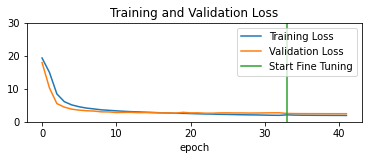

In [45]:
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 30.0])
plt.plot([33,33],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### Retrieving of the model without the CTC layer

In [46]:
transfer_learning_model = tf.keras.models.Model(
    model.get_layer(name="input").input, model.get_layer(name="dense2").output
)

#### Retrieving of the prediction for calculating the characters and words predicted score

In [47]:
preds = transfer_learning_model.predict(x_valid)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

In [48]:
# Function for convert the labels from digits to characters representation
def nums_to_labels(out):
    # Input:
    # out is the digit representation of the label
    # Output:
    # characters representation of the label
    
    ret = ""
    for ch in out:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=characters[ch]
    return ret

In [49]:
predictions = list(map(nums_to_labels, decoded))

In [50]:
correct_char = 0
total_char = 0
correct = 0

for i in range(3000):
    pr = predictions[i]
    tr = y_valid[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/3000))

Correct characters predicted : 89.48%
Correct words predicted      : 74.10%


## Correct characters predicted: 89,48%
## Correct words predicted: 74,10%

#### Test of the trained model on the test set

In [51]:
test = pd.read_csv('dataset/written_name_test_v2.csv')

In [52]:
print("Number of NaNs in test set      : ", test['IDENTITY'].isnull().sum())

Number of NaNs in test set      :  70


In [53]:
test.dropna(axis=0, inplace=True)

In [54]:
test = test[test['IDENTITY'] != 'UNREADABLE']

In [55]:
test['IDENTITY'] = test['IDENTITY'].str.upper()

In [56]:
test.reset_index(inplace = True, drop=True) 

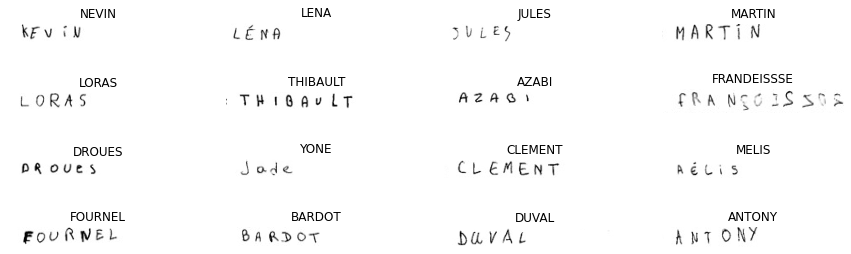

In [57]:
plt.figure(figsize=(15, 10))

images= []
i = 0

while len(images) < 16:
  img_dir = 'dataset/test_v2/test/' + test.loc[i, 'FILENAME']
  image, entropy = crop_picture(img_dir)
  if not image is None:
    images.append(image)
  i += 1

i = 0
for image in images:
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(image, cmap='gray')
  image = imageResize(image)
  image = image/255.
  pred = transfer_learning_model.predict(image.reshape(1, 200, 50, 1))
  decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                     greedy=True)[0][0])
  plt.title(nums_to_labels(decoded[0]), fontsize=12)
  plt.axis('off')
  i += 1
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)